# Problem Statement

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

 

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone. A typical lead conversion process can be represented using the following funnel:

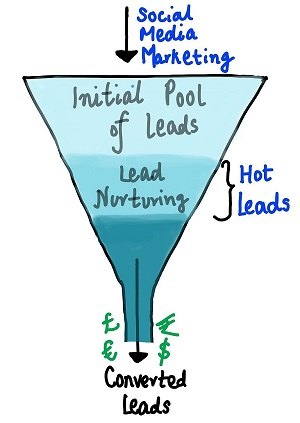

As you can see, there are a lot of leads generated in the initial stage (top) but only a few of them come out as paying customers from the bottom. In the middle stage, you need to nurture the potential leads well (i.e. educating the leads about the product, constantly communicating etc. ) in order to get a higher lead conversion.

 

X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### Data

You have been provided with a leads dataset from the past with around 9000 data points. This dataset consists of various attributes such as Lead Source, Total Time Spent on Website, Total Visits, Last Activity, etc. which may or may not be useful in ultimately deciding whether a lead will be converted or not. The target variable, in this case, is the column ‘Converted’ which tells whether a past lead was converted or not wherein 1 means it was converted and 0 means it wasn’t converted. You can learn more about the dataset from the data dictionary provided in the zip folder at the end of the page. Another thing that you also need to check out are the levels present in the categorical variables. Many of the categorical variables have a level called 'Select' which needs to be handled because it is as good as a null value (think why?).

## Goals of the case study

There are quite a few goals for this case study:

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

# Solution

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

## Common Functions to be used in the solutions

1. **get_dt_graph:** This will create and plot graphs for the solutions
2. **evaluate_model:** This will evaluate the models against for Accuracy and Confusion Matrix
3. **draw_roc:** This function generates and displays the Receiver Operating Characteristic (ROC) curve for a given set of actual labels and predicted probabilities. It calculates the false positive rate (FPR) and true positive rate (TPR) at various threshold settings, computes the Area Under the ROC Curve (AUC), and plots the ROC curve along with the AUC score. The function includes a diagonal reference line representing random guessing. The plot is displayed with labeled axes and a legend indicating the AUC score.

In [385]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [386]:
def get_dt_graph(dt_classifier, columns, class_names):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=columns, 
                    class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [387]:
def evaluate_model(dt_classifier, y_train, X_train, y_test, X_test):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [388]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## 1. Reading & understanding the dataset

In [389]:
leads = pd.read_csv('Leads.csv')
leads.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [390]:
leads.shape

(9240, 37)

In [391]:
leads.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
max                     20.000000

In [392]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

##  2. Data Cleaning 
### -Formating the data as required to process them.
1. Removing the rownumbers.
2. Treating null values.
3. Dropping unnecessary columns for analysis. 


Removing Index columns
Check if any duplicate values are present in the index columns here. If present It has to be treated, else they can be dropped as it is not relavent for data analysis.
The first two columns 'Prospect ID' and 'Lead Number' are the two index columns in this dataset.

In [393]:
sum(leads.duplicated(subset = 'Prospect ID')) == 0
sum(leads.duplicated(subset = 'Lead Number')) == 0

True

Since there are no duplicate values, we remove these columns from the dataframe.

In [394]:
#dropping indexes
leads.drop(['Prospect ID', 'Lead Number'], axis=1, inplace = True)

In [395]:
# Replacing the select variable with NaN
leads = leads.replace('Select', np.nan)

In [396]:
leads.isnull().sum()

Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

In [397]:
leads.index

RangeIndex(start=0, stop=9240, step=1)

### Handling Null Values

In [398]:
#check the percentage of nulls
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [399]:
# drop columns with 40% or more null values.
colum=leads.columns

for i in colum:
    if((100*(leads[i].isnull().sum()/len(leads.index))) >= 40):
        leads.drop(i, axis = 1, inplace = True)

In [400]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [401]:
# Analysing the value_count of City column as it has the highest amount of nulls, after dropping columns having 40% or above null values.
leads['City'].value_counts(dropna=False)

City
NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

Since most of the values are generated from the city 'Mumbai' we replace the null values also with 'Mumbai'.

In [402]:
leads['City'] = leads['City'].replace(np.nan,'Unknown')
# Rajesh: Is this the right way to impute? Can we not replace it with 'Other Cities' instead?

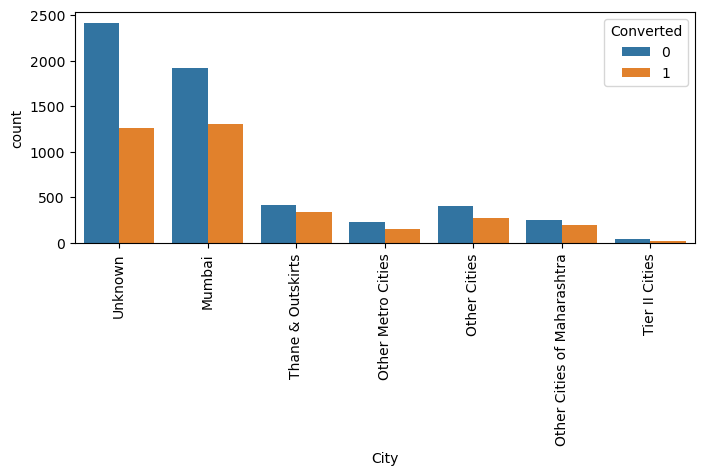

In [403]:
plt.figure(figsize=(8,3))
spr=sns.countplot(x=leads.City, hue=leads.Converted)
spr.set_xticklabels(spr.get_xticklabels(),rotation=90)
plt.show()

In [404]:
#Treating the next highest null Values 'Specialization'
leads['Specialization'].value_counts(dropna=False)

Specialization
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: count, dtype: int64

In [405]:
#Since NaN has max values, we replace it as a category to consider it while calculating conversion rate.
leads['Specialization'] = leads['Specialization'].replace(np.nan, 'None')

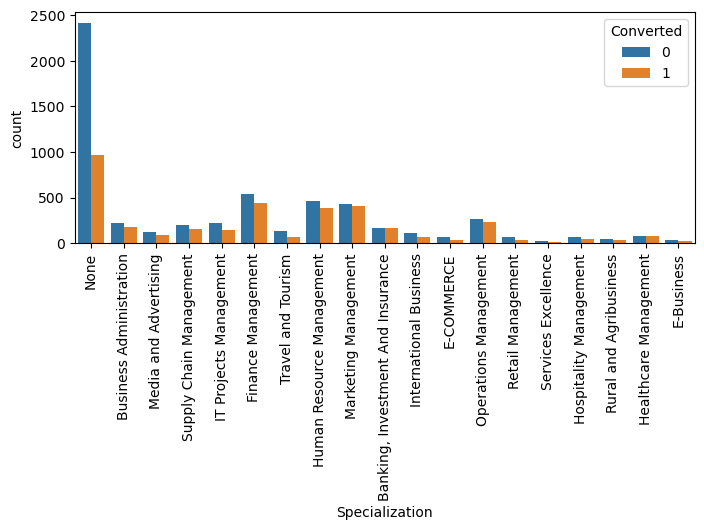

In [406]:

plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Specialization, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

A few of these categories are actually sub-caterogy of management stream, hence replacing all of it by 'Management_Specialization'.

In [407]:
#Management_Specialization
leads['Specialization'] = leads['Specialization'].replace(['Finance Management','Human Resource Management',
                                                           'Marketing Management','Operations Management',
                                                           'IT Projects Management','Supply Chain Management',
                                                    'Healthcare Management','Hospitality Management',
                                                           'Retail Management'] ,'Management_Specializations')  

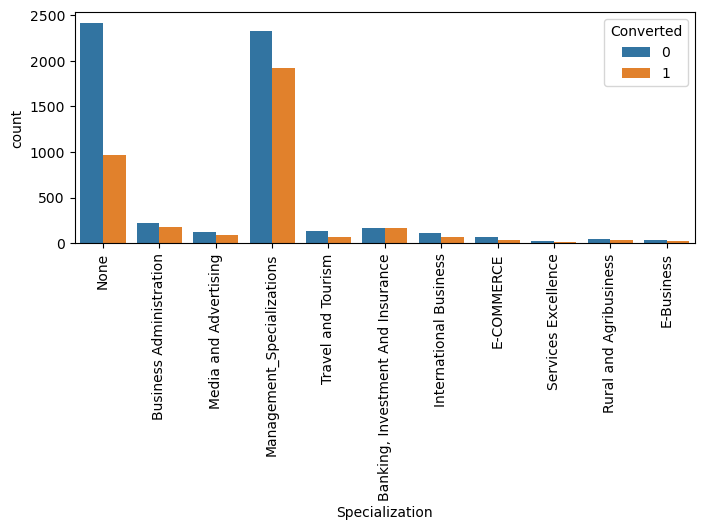

In [408]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Specialization, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [409]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [410]:
leads['Tags'].value_counts(dropna=False)

Tags
NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch 

In [411]:
leads['Tags'] = leads['Tags'].replace(np.nan,'None')

In [412]:
leads['Tags'] = leads['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized','switched off','Already a student','Not doing further education','invalid number',
                                    'wrong number given','Interested  in full time MBA'], 'Other_Tags')


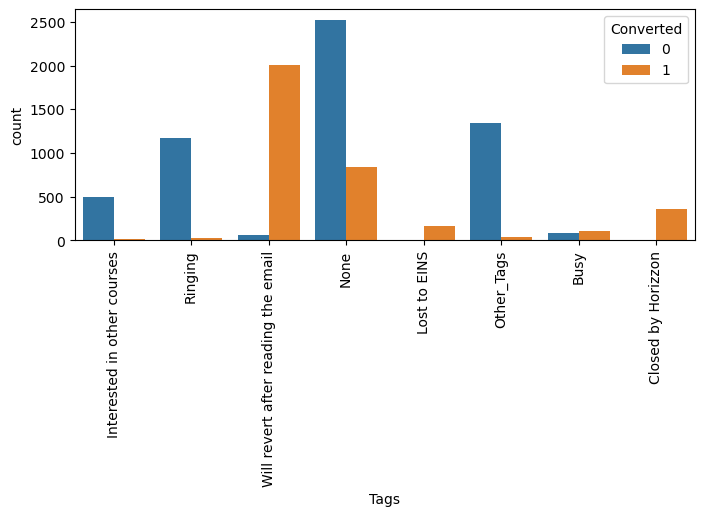

In [413]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Tags'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [414]:
#next highest null values
leads['What is your current occupation'].value_counts(dropna=False)

What is your current occupation
Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: count, dtype: int64

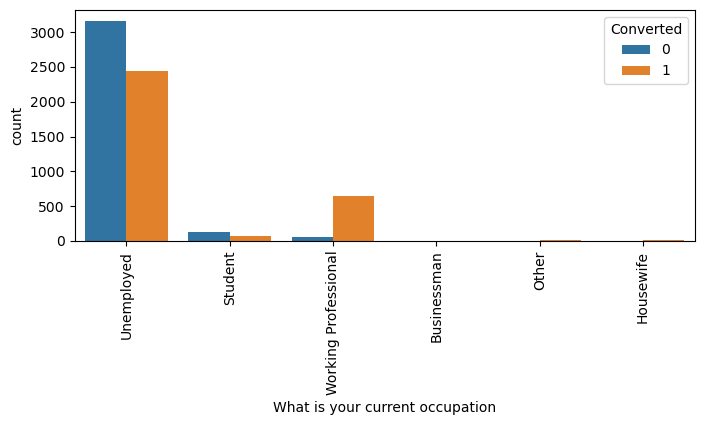

In [415]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What is your current occupation'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [416]:
# Rajesh: 'Can we create another tag as "Unknown" instead?'
leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.nan, 'Unemployed')

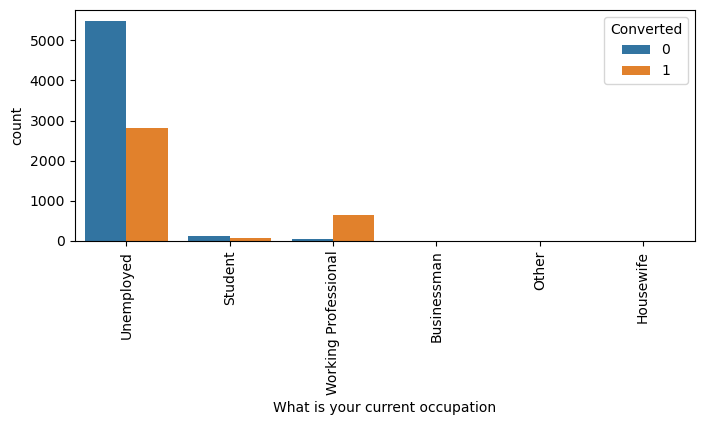

In [417]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What is your current occupation'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [418]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [419]:
leads['What matters most to you in choosing a course'] = leads['What matters most to you in choosing a course'].replace(np.nan,'Better Career Prospects')

In [420]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

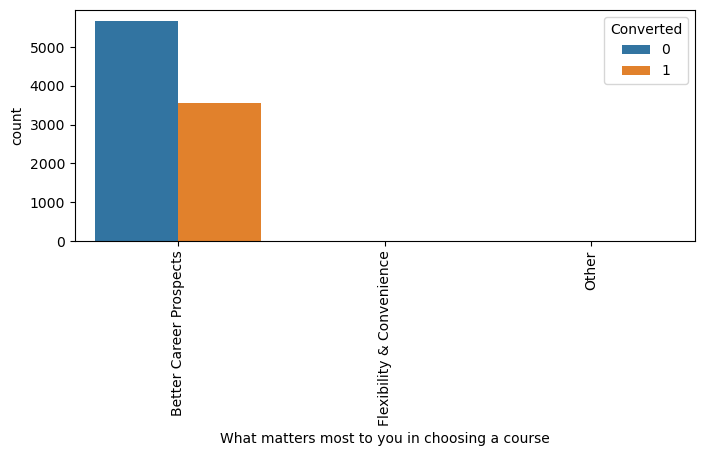

In [421]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What matters most to you in choosing a course'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [422]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [423]:
cols_to_drop=['What matters most to you in choosing a course']

Checking if all nulls have been treated appropriately

In [424]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [425]:
leads['Country'].value_counts(dropna=False)

Country
India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switze

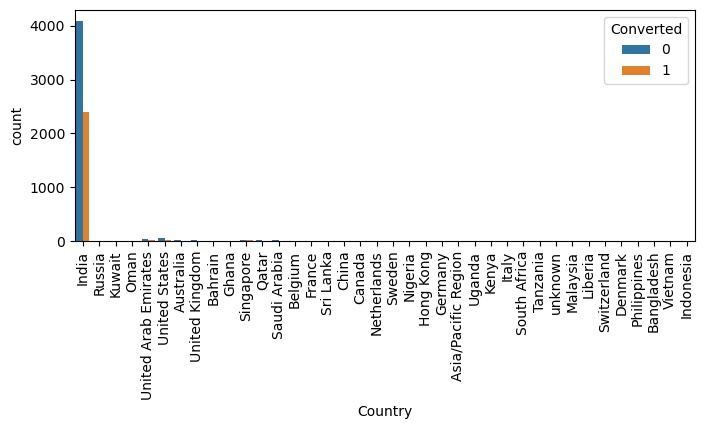

In [426]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Country, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [427]:
cols_to_drop.append('Country')
cols_to_drop

['What matters most to you in choosing a course', 'Country']

In [428]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [429]:
leads['Lead Source'].value_counts(dropna=False)

Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: count, dtype: int64

In [430]:
leads['Lead Source'] = leads['Lead Source'].replace(np.nan,'Others')
leads['Lead Source'] = leads['Lead Source'].replace('google','Google')
leads['Lead Source'] = leads['Lead Source'].replace('Facebook','Social Media')
leads['Lead Source'] = leads['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM'] ,'Others')

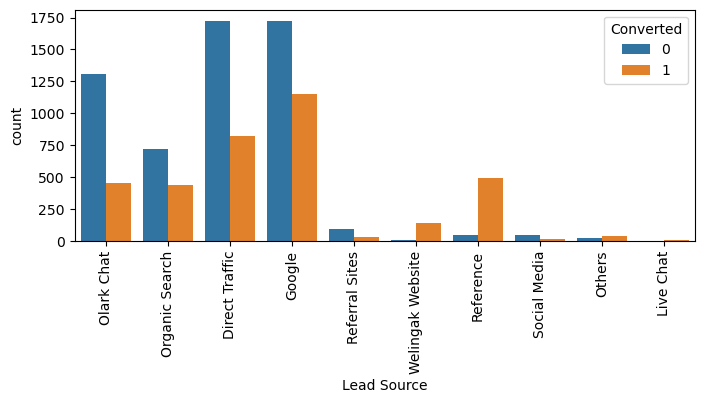

In [431]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Lead Source'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [432]:
leads['Last Activity'].value_counts(dropna=False)

Last Activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: count, dtype: int64

In [433]:
leads['Last Activity'] = leads['Last Activity'].replace(np.nan,'Others')
leads['Last Activity'] = leads['Last Activity'].replace(['Unreachable','Unsubscribed',
                                                        'Had a Phone Conversation', 
                                                        'Approached upfront',
                                                        'View in browser link Clicked',       
                                                        'Email Marked Spam',                  
                                                        'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

In [434]:
leads['Last Activity'].value_counts(dropna=False)

Last Activity
Email Opened                 3437
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Others                        308
Email Link Clicked            267
Form Submitted on Website     116
Name: count, dtype: int64

In [435]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     0.00
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [436]:
# Rajesh: Can we not impute instead of dropping the country which has 26% of data?
leads[['Country', 'City']]

Country                         City
0                      NaN                      Unknown
1                    India                      Unknown
2                    India                       Mumbai
3                    India                       Mumbai
4                    India                       Mumbai
5                      NaN                      Unknown
6                    India                       Mumbai
7                      NaN                      Unknown
8                    India            Thane & Outskirts
9                    India                       Mumbai
10                   India           Other Metro Cities
11                   India            Thane & Outskirts
12                   India                      Unknown
13                   India            Thane & Outskirts
14                  Russia                      Unknown
15                   India                      Unknown
16                     NaN                      Unknown
17                   India                      Unknown
18                   India                       Mumbai
19                   India                      Unknown
20                   India                       Mumbai
21                   India                      Unknown
22                   India                       Mumbai
23                   India                       Mumbai
24                   India                       Mumbai
25                   India                       Mumbai
26                   India                 Other Cities
27                   India                       Mumbai
28                   India                       Mumbai
29                   India                       Mumbai
30                   India                       Mumbai
31                   India                      Unknown
32                   India                      Unknown
33                   India                      Unknown
34                   India                       Mumbai
35                   India            Thane & Outskirts
36                   India                       Mumbai
37                   India                       Mumbai
38                   India                      Unknown
39                   India  Other Cities of Maharashtra
40                   India                      Unknown
41                   India                       Mumbai
42                   India                      Unknown
43                   India                       Mumbai
44                   India                       Mumbai
45                   India                       Mumbai
46                   India                       Mumbai
47                     NaN                      Unknown
48                   India            Thane & Outskirts
49                     NaN                      Unknown
50                     NaN            Thane & Outskirts
51                   India                       Mumbai
52                   India                       Mumbai
53                   India                      Unknown
54                   India                      Unknown
55                   India                      Unknown
56                   India           Other Metro Cities
57                   India  Other Cities of Maharashtra
58                   India                       Mumbai
59                   India            Thane & Outskirts
60                   India                       Mumbai
61                     NaN                      Unknown
62                   India                       Mumbai
63                     NaN                      Unknown
64                   India                 Other Cities
65                   India  Other Cities of Maharashtra
66                   India                       Mumbai
67                     NaN  Other Cities of Maharashtra
68                     NaN                      Unknown
69                     NaN                      Unknown
70                   India            Thane

In [446]:
df_filtered = leads[~((leads['Country'] == None) & (leads['City'] == 'Unknown'))]
df_filtered[['City', 'Country']]

Empty DataFrame
Columns: [City, Country]
Index: []

In [233]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                        0.0
Digital Advertisement                         

All the values are now non-zero. Now that all the nulls are treated, we compare the variables.

In [234]:
leads['Lead Origin'].value_counts(dropna=False)

Lead Origin
Landing Page Submission    4850
API                        1902
Lead Add Form                27
Name: count, dtype: int64

# 3. Exploratory Data Analysis

Plotting a graph of count plot between converted and the count of Leads Originated.

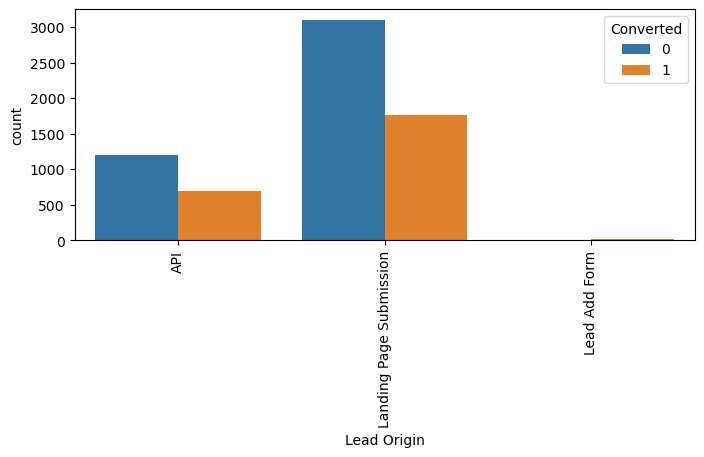

In [235]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Lead Origin'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

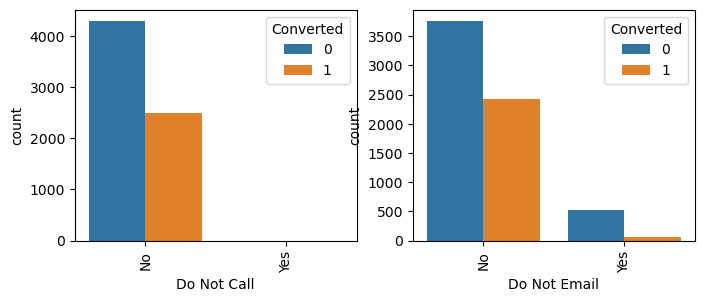

In [236]:
#Plotting Do not call and Do not Email variables against the converted varilable.
plt.figure(figsize=(8,3))

ax1=plt.subplot(1, 2, 1)
ax1=sns.countplot(x=leads['Do Not Call'], hue=leads.Converted)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2=plt.subplot(1, 2, 2)
ax2=sns.countplot(x=leads['Do Not Email'], hue=leads.Converted)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
plt.show()

In [237]:
# Checking actual count of the variable value
leads['Do Not Call'].value_counts(dropna=False)

Do Not Call
No     6778
Yes       1
Name: count, dtype: int64

In [238]:
# Checking actual count of the variable value
leads['Do Not Email'].value_counts(dropna=False)

Do Not Email
No     6186
Yes     593
Name: count, dtype: int64

In [239]:
# Since the variable 'Do not Call' is highly biased, we plan to drop the variable
cols_to_drop.append('Do Not Call')
cols_to_drop

['What matters most to you in choosing a course', 'Country', 'Do Not Call']

In [240]:
leads.Search.value_counts(dropna=False)

Search
No     6765
Yes      14
Name: count, dtype: int64

In [241]:
leads['Newspaper Article'].value_counts(dropna=False)

Newspaper Article
No     6777
Yes       2
Name: count, dtype: int64

In [242]:
leads['X Education Forums'].value_counts(dropna=False)

X Education Forums
No     6778
Yes       1
Name: count, dtype: int64

In [243]:
leads['Newspaper'].value_counts(dropna=False)

Newspaper
No     6778
Yes       1
Name: count, dtype: int64

In [244]:
leads['Digital Advertisement'].value_counts(dropna=False)

Digital Advertisement
No     6775
Yes       4
Name: count, dtype: int64

In [245]:
leads['Through Recommendations'].value_counts(dropna=False)

Through Recommendations
No     6772
Yes       7
Name: count, dtype: int64

In [246]:
leads['Receive More Updates About Our Courses'].value_counts(dropna=False)

Receive More Updates About Our Courses
No    6779
Name: count, dtype: int64

In [247]:
leads['Update me on Supply Chain Content'].value_counts(dropna=False)

Update me on Supply Chain Content
No    6779
Name: count, dtype: int64

In [248]:
leads['Get updates on DM Content'].value_counts(dropna=False)

Get updates on DM Content
No    6779
Name: count, dtype: int64

In [249]:
leads['I agree to pay the amount through cheque'].value_counts(dropna=False)

I agree to pay the amount through cheque
No    6779
Name: count, dtype: int64

In [250]:
leads['A free copy of Mastering The Interview'].value_counts(dropna=False)

A free copy of Mastering The Interview
No     3913
Yes    2866
Name: count, dtype: int64

In [251]:
cols_to_drop.extend(['Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
                 'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content',
                 'Get updates on DM Content','I agree to pay the amount through cheque'])

In [252]:
leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        2331
Email Opened                    2212
SMS Sent                        1643
Page Visited on Website          286
Email Link Clicked               106
Olark Chat Conversation           68
Email Bounced                     48
Unsubscribed                      40
Unreachable                       26
Had a Phone Conversation          14
Approached upfront                 1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Email Marked Spam                  1
Name: count, dtype: int64

In [253]:
leads['Last Notable Activity'] = leads['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam',
                                                                         'Unreachable',
                                                                         'Unsubscribed',
                                                                         'Email Bounced',                                                                    
                                                                       'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 
                                                                       'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')


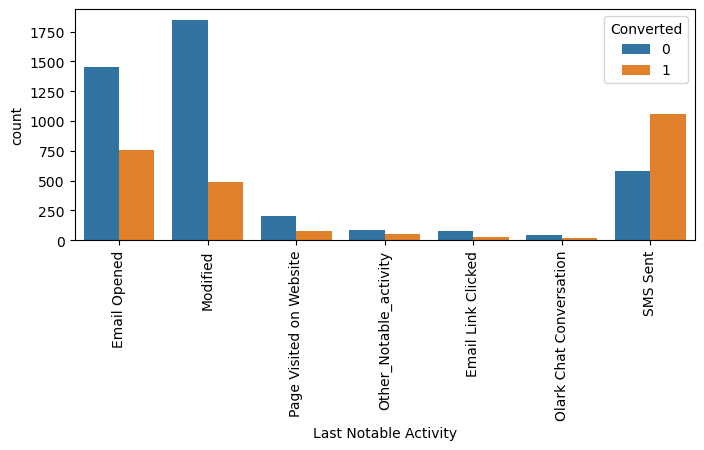

In [254]:

plt.figure(figsize = (8,3))
ax1=sns.countplot(x = "Last Notable Activity", hue = "Converted", data = leads)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
plt.show()

In [255]:
leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                   2331
Email Opened               2212
SMS Sent                   1643
Page Visited on Website     286
Other_Notable_activity      133
Email Link Clicked          106
Olark Chat Conversation      68
Name: count, dtype: int64

In [256]:
cols_to_drop

['What matters most to you in choosing a course',
 'Country',
 'Do Not Call',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque']

In [257]:
leads = leads.drop(cols_to_drop,axis = 1)
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6779 entries, 1 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             6779 non-null   object 
 1   Lead Source                             6779 non-null   object 
 2   Do Not Email                            6779 non-null   object 
 3   Converted                               6779 non-null   int64  
 4   TotalVisits                             6779 non-null   float64
 5   Total Time Spent on Website             6779 non-null   int64  
 6   Page Views Per Visit                    6779 non-null   float64
 7   Last Activity                           6779 non-null   object 
 8   Specialization                          6779 non-null   object 
 9   What is your current occupation         6779 non-null   object 
 10  Tags                                    6779 non-null   object 
 

In [258]:
Converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
Converted

36.65732408909869

In [259]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6779 entries, 1 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             6779 non-null   object 
 1   Lead Source                             6779 non-null   object 
 2   Do Not Email                            6779 non-null   object 
 3   Converted                               6779 non-null   int64  
 4   TotalVisits                             6779 non-null   float64
 5   Total Time Spent on Website             6779 non-null   int64  
 6   Page Views Per Visit                    6779 non-null   float64
 7   Last Activity                           6779 non-null   object 
 8   Specialization                          6779 non-null   object 
 9   What is your current occupation         6779 non-null   object 
 10  Tags                                    6779 non-null   object 
 

### Now that all data is set, we find the correlation matrix of numeric variables.

In [260]:
numcol= leads.select_dtypes(include=['int64','float64']).columns
corl=leads[numcol]

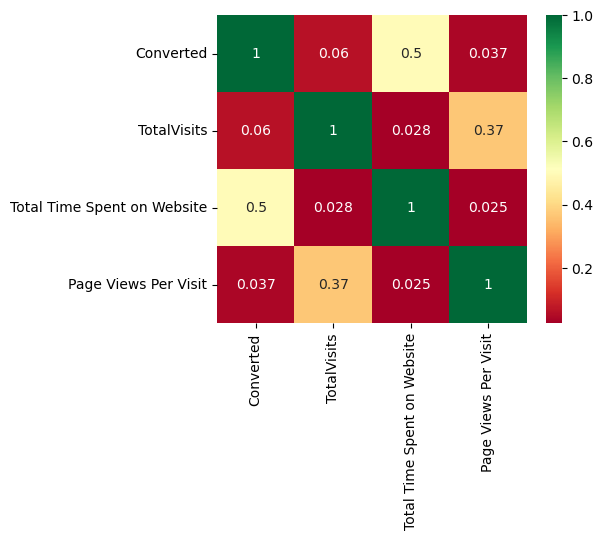

In [261]:
plt.figure(figsize=(5,4))

# heatmap
sns.heatmap(data=corl.corr(), cmap="RdYlGn", annot=True)
plt.show()

### Analysis-
1. Converted has highest corelation with the total time spent on website, which means more time spent on the website will be a potential lead worthy of conversion.
2. Also, page views per visit has the least corelation with converted variable, which means the conversion rate cannot be predicted with the number of pages viewed on a visit.


### Handling Outliers

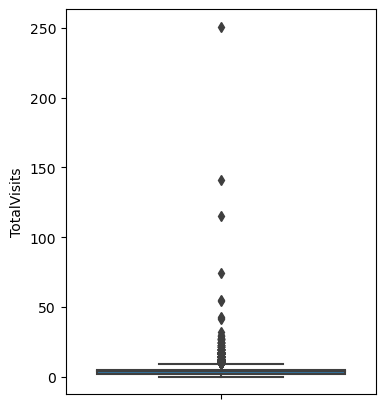

In [262]:
plt.figure(figsize=(4,5))
sns.boxplot(y=leads['TotalVisits'])
plt.show()

In [263]:
#bucketing the total Visits values
leads['TotalVisits'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    6779.000000
mean        4.553917
std         5.138148
min         0.000000
5%          1.000000
25%         2.000000
50%         4.000000
75%         5.000000
90%         8.000000
95%        11.000000
99%        18.220000
max       251.000000
Name: TotalVisits, dtype: float64

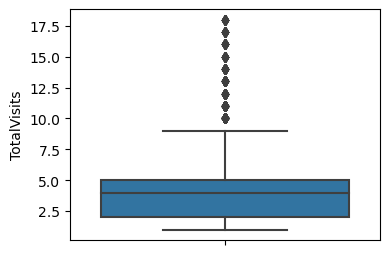

In [264]:
# working on the interquartile range of qtr3 and qtr1

plt.figure(figsize=(4,3))
Q3 = leads.TotalVisits.quantile(0.99)
leads = leads[(leads.TotalVisits <= Q3)]
Q1 = leads.TotalVisits.quantile(0.01)
leads = leads[(leads.TotalVisits >= Q1)]
sns.boxplot(y=leads['TotalVisits'])
plt.show()

In [265]:
leads.shape

(6706, 14)

In [266]:
#bucketing the 'Total Time Spent on Website' values
leads['Total Time Spent on Website'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    6706.000000
mean      631.736206
std       541.763382
min         0.000000
5%         33.000000
25%       171.000000
50%       397.000000
75%      1104.000000
90%      1451.500000
95%      1606.000000
99%      1862.950000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

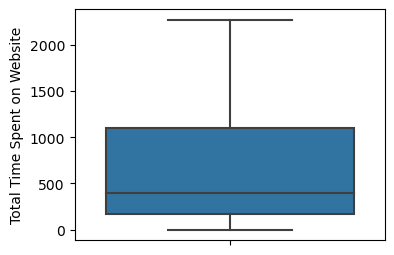

In [267]:
plt.figure(figsize=(4,3))
sns.boxplot(y=leads['Total Time Spent on Website'])
plt.show()

In [268]:
leads['Page Views Per Visit'].describe()


count    6706.000000
mean        3.104545
std         1.817244
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

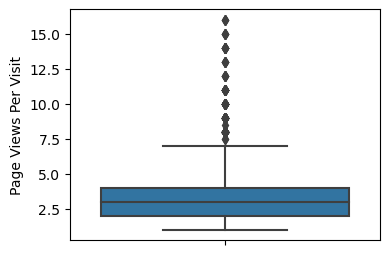

In [269]:
plt.figure(figsize=(4,3))
sns.boxplot(y=leads['Page Views Per Visit'])
plt.show()

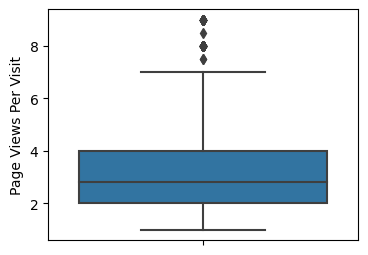

In [270]:
# working on the interquartile range of qtr3 and qtr1

plt.figure(figsize=(4,3))
Q3 = leads['Page Views Per Visit'].quantile(0.99)
leads = leads[leads['Page Views Per Visit'] <= Q3]
Q1 = leads['Page Views Per Visit'].quantile(0.01)
leads = leads[leads['Page Views Per Visit'] >= Q1]
sns.boxplot(y=leads['Page Views Per Visit'])
plt.show()

In [271]:
leads.shape

(6640, 14)

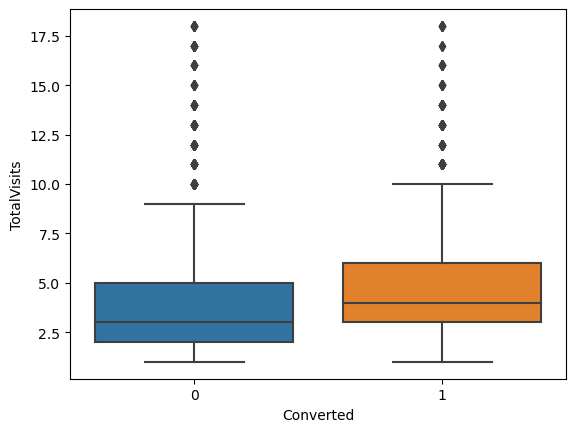

In [272]:
# Plotting a boxplot for converted and total visits.
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = leads)
plt.show()

### Analysis-
1. The not converted vs converted mean are around the same region, whereas the amount of conversion is fairly smaller.
The upper quartile is almost the same for both converted and not converted categories.

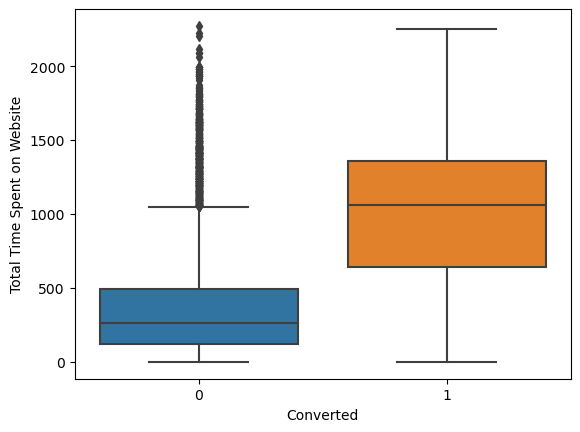

In [273]:
sns.boxplot(x=leads.Converted, y=leads['Total Time Spent on Website'])
plt.show()

### analysis-
As seen earlier, higher the time spent on the webpage, higher is the conversion rate of the lead.
Thus those custmers who spend more time on the web page should be considered high potential leads.

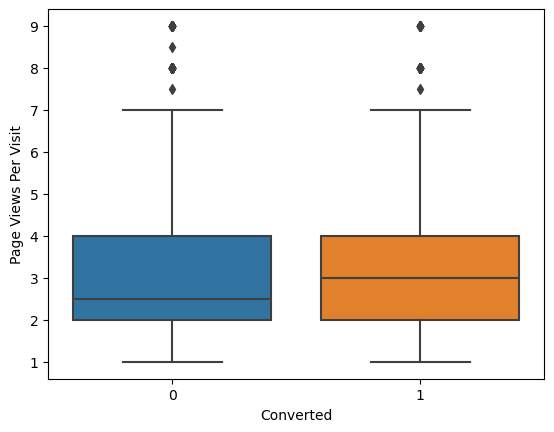

In [274]:
sns.boxplot(x=leads.Converted,y=leads['Page Views Per Visit'])
plt.show()

### Analysis-
1. The median of the average page views for converted is higher than for not converted.
2. If a lead views more number of pages as compared to the average number of page visits, they can be considered as a potential leads.

In [275]:
round(100*(leads.isnull().sum()/len(leads.index)),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Specialization                            0.0
What is your current occupation           0.0
Tags                                      0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

In [276]:
catcol= leads.select_dtypes(include=['object']).columns
catcol

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

## Define the target variable

### The target variable: (Converted)
* The target variable Converted indicates whether a lead was successfully turned into a paying customer, with a value of 1 representing conversion and 0 representing non-conversion.
* In the provided dataset, Converted serves as the outcome that the model will predict, helping X Education identify the leads most likely to result in sales.
* The goal is to maximize the Converted rate by focusing efforts on leads with the highest potential, as determined by the model's lead scoring system.

In [277]:
leads['Converted'].value_counts()

Converted
0    4219
1    2421
Name: count, dtype: int64

## Create dummy variables for the independent variables

In [278]:
catcol


Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [279]:
for col in catcol:
     
     print('\n\n',leads[col].value_counts())
   



 Lead Origin
Landing Page Submission    4747
API                        1871
Lead Add Form                22
Name: count, dtype: int64


 Lead Source
Google              2822
Direct Traffic      2483
Organic Search      1085
Referral Sites       114
Olark Chat            96
Others                16
Reference             16
Welingak Website       5
Social Media           3
Name: count, dtype: int64


 Do Not Email
No     6072
Yes     568
Name: count, dtype: int64


 Last Activity
Email Opened                 2602
SMS Sent                     2049
Page Visited on Website       558
Converted to Lead             420
Olark Chat Conversation       314
Email Bounced                 258
Others                        165
Email Link Clicked            163
Form Submitted on Website     111
Name: count, dtype: int64


 Specialization
Management_Specializations           3706
None                                 1492
Business Administration               358
Banking, Investment And Insurance     

In [280]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(leads[catcol], drop_first=True)

# Adding the results to the master dataframe
leads = pd.concat([leads, dummy], axis=1)

In [281]:
leads.head()

Lead Origin     Lead Source Do Not Email  Converted  \
1                      API  Organic Search           No          0   
2  Landing Page Submission  Direct Traffic           No          1   
3  Landing Page Submission  Direct Traffic           No          0   
4  Landing Page Submission          Google           No          1   
6  Landing Page Submission          Google           No          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   
6          2.0                         1640                   2.0   

       Last Activity              Specialization  \
1       Email Opened                        None   
2       Email Opened     Business Administration   
3             Others       Media and Advertising   
4  Converted to Lead                        None   
6       Email Opened  Management_Specializations   

  What is your current occupation                                 Tags  \
1                      Unemployed                              Ringing   
2                         Student  Will revert after reading the email   
3                      Unemployed                              Ringing   
4                      Unemployed  Will revert after reading the email   
6                      Unemployed  Will revert after reading the email   

     City A free copy of Mastering The Interview Last Notable Activity  \
1  Mumbai                                     No          Email Opened   
2  Mumbai                                    Yes          Email Opened   
3  Mumbai                                     No              Modified   
4  Mumbai                                     No              Modified   
6  Mumbai                                     No              Modified   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1                                False                      False   
2                                 True                      False   
3                                 True                      False   
4                                 True                      False   
6                                 True                      False   

   Lead Source_Google  Lead Source_Olark Chat  Lead Source_Organic Search  \
1               False                   False                        True   
2               False                   False                       False   
3               False                   False                       False   
4                True                   False                       False   
6                True                   False                       False   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral Sites  \
1               False                  False                       False   
2               False                  False                       False   
3               False                  False                       False   
4               False                  False                       False   
6               False                  False                       False   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
1                     False                         False             False   
2                     False                         False             False   
3                     False                         False             False   
4                     False                         False             False   
6                     False                         False             False   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
1                        False                             False   
2                        False

In [282]:
leads=leads.drop(catcol,axis=1)

In [283]:
leads.head()

Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1          0          5.0                          674                   2.5   
2          1          2.0                         1532                   2.0   
3          0          1.0                          305                   1.0   
4          1          2.0                         1428                   1.0   
6          1          2.0                         1640                   2.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1                                False                      False   
2                                 True                      False   
3                                 True                      False   
4                                 True                      False   
6                                 True                      False   

   Lead Source_Google  Lead Source_Olark Chat  Lead Source_Organic Search  \
1               False                   False                        True   
2               False                   False                       False   
3               False                   False                       False   
4                True                   False                       False   
6                True                   False                       False   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral Sites  \
1               False                  False                       False   
2               False                  False                       False   
3               False                  False                       False   
4               False                  False                       False   
6               False                  False                       False   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
1                     False                         False             False   
2                     False                         False             False   
3                     False                         False             False   
4                     False                         False             False   
6                     False                         False             False   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
1                        False                             False   
2                        False                             False   
3                        False                             False   
4                        False                             False   
6                        False                             False   

   Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
1                        True                                    False   
2                        True                                    False   
3                       False                                    False   
4                       False                                    False   
6                        True                                    False   

   Last Activity_Olark Chat Conversation  Last Activity_Others  \
1                                  False                 False   
2                                  False                 False   
3                                  False                  True   
4                                  False                 False   
6                                  False                 False   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
1                                  False                   False   
2                                  False                   False   
3                                  False                   False   
4                                  False                   False   
6                                  False                   False   

   Specialization_Business Administration  Specializ

In [284]:
catcol= leads.select_dtypes(include=['bool']).columns
catcol

Index(['Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Others',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_Welingak Website',
       'Do Not Email_Yes', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Opened',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Others',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_International Business',
       'Specialization_Management_Specializations',
       'Specialization_Media and Advertising', 'Specialization_None',
       'Specialization_Rural and Agribusiness',
       'Specialization_Service

In [285]:
for col in catcol:
    leads[col]=leads[col].astype(int)

In [286]:
leads.head()

Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1          0          5.0                          674                   2.5   
2          1          2.0                         1532                   2.0   
3          0          1.0                          305                   1.0   
4          1          2.0                         1428                   1.0   
6          1          2.0                         1640                   2.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   
6                                    1                          0   

   Lead Source_Google  Lead Source_Olark Chat  Lead Source_Organic Search  \
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   
6                   1                       0                           0   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral Sites  \
1                   0                      0                           0   
2                   0                      0                           0   
3                   0                      0                           0   
4                   0                      0                           0   
6                   0                      0                           0   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
1                         0                             0                 0   
2                         0                             0                 0   
3                         0                             0                 0   
4                         0                             0                 0   
6                         0                             0                 0   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   
6                            0                                 0   

   Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
1                           1                                        0   
2                           1                                        0   
3                           0                                        0   
4                           0                                        0   
6                           1                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Others  \
1                                      0                     0   
2                                      0                     0   
3                                      0                     1   
4                                      0                     0   
6                                      0                     0   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
1                                      0                       0   
2                                      0                       0   
3                                      0                       0   
4                                      0                       0   
6                                      0                       0   

   Specialization_Business Administration  Specializ

## Training - Test Data Split

##### Putting feature variable to X

In [287]:
X = leads.drop(['Converted'], axis=1)

X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   
6          2.0                         1640                   2.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   
6                                    1                          0   

   Lead Source_Google  Lead Source_Olark Chat  Lead Source_Organic Search  \
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   
6                   1                       0                           0   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral Sites  \
1                   0                      0                           0   
2                   0                      0                           0   
3                   0                      0                           0   
4                   0                      0                           0   
6                   0                      0                           0   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
1                         0                             0                 0   
2                         0                             0                 0   
3                         0                             0                 0   
4                         0                             0                 0   
6                         0                             0                 0   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   
6                            0                                 0   

   Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
1                           1                                        0   
2                           1                                        0   
3                           0                                        0   
4                           0                                        0   
6                           1                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Others  \
1                                      0                     0   
2                                      0                     0   
3                                      0                     1   
4                                      0                     0   
6                                      0                     0   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
1                                      0                       0   
2                                      0                       0   
3                                      0                       0   
4                                      0                       0   
6                                      0                       0   

   Specialization_Business Administration  Specialization_E-Business  \
1                                       0     

##### Putting response variable to y

In [288]:
y=leads['Converted']
y.head()

1    0
2    1
3    0
4    1
6    1
Name: Converted, dtype: int64

##### Splitting the data set into test and train

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [290]:
X_train.shape

(4648, 56)

In [291]:
y_train.shape

(4648,)

In [292]:
X_test.shape

(1992, 56)

In [293]:
y_test.shape

(1992,)

## Fine tuning and Analysis

##### Feature Scaling the numerical variables

In [294]:
numcol

Index(['Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit'],
      dtype='object')

In [295]:
scaler = StandardScaler()

X_train[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1979     0.668033                     1.836717              1.846001   
6249     1.418399                     1.230405             -0.225650   
5557     1.793583                     1.857051              3.712353   
7865     1.793583                    -0.645835              3.712353   
8491    -0.082334                     0.086176              0.601766   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1979                                    1                          0   
6249                                    1                          0   
5557                                    1                          0   
7865                                    1                          0   
8491                                    1                          0   

      Lead Source_Google  Lead Source_Olark Chat  Lead Source_Organic Search  \
1979                   1                       0                           0   
6249                   1                       0                           0   
5557                   0                       0                           0   
7865                   1                       0                           0   
8491                   1                       0                           0   

      Lead Source_Others  Lead Source_Reference  Lead Source_Referral Sites  \
1979                   0                      0                           0   
6249                   0                      0                           0   
5557                   0                      0                           0   
7865                   0                      0                           0   
8491                   0                      0                           0   

      Lead Source_Social Media  Lead Source_Welingak Website  \
1979                         0                             0   
6249                         0                             0   
5557                         0                             0   
7865                         0                             0   
8491                         0                             0   

      Do Not Email_Yes  Last Activity_Email Bounced  \
1979                 0                            0   
6249                 0                            0   
5557                 0                            0   
7865                 0                            0   
8491                 0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Opened  \
1979                                 0                           0   
6249                                 0                           1   
5557                                 0                           1   
7865                                 0                           1   
8491                                 0                           1   

      Last Activity_Form Submitted on Website  \
1979                                        0   
6249                                        0   
5557                                        0   
7865                                        0   
8491                                        0   

      Last Activity_Olark Chat Conversation  Last Activity_Others  \
1979                                      0                     0   
6249                                      0                     0   
5557                                      0                     0   
7865                                      0                     0   
8491                                      0                     0   

      Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
1979                                      0                       1   
6249                                      0                       0   
5557                                      0                       0   
7865                                      0          

#### Looking at the correlations

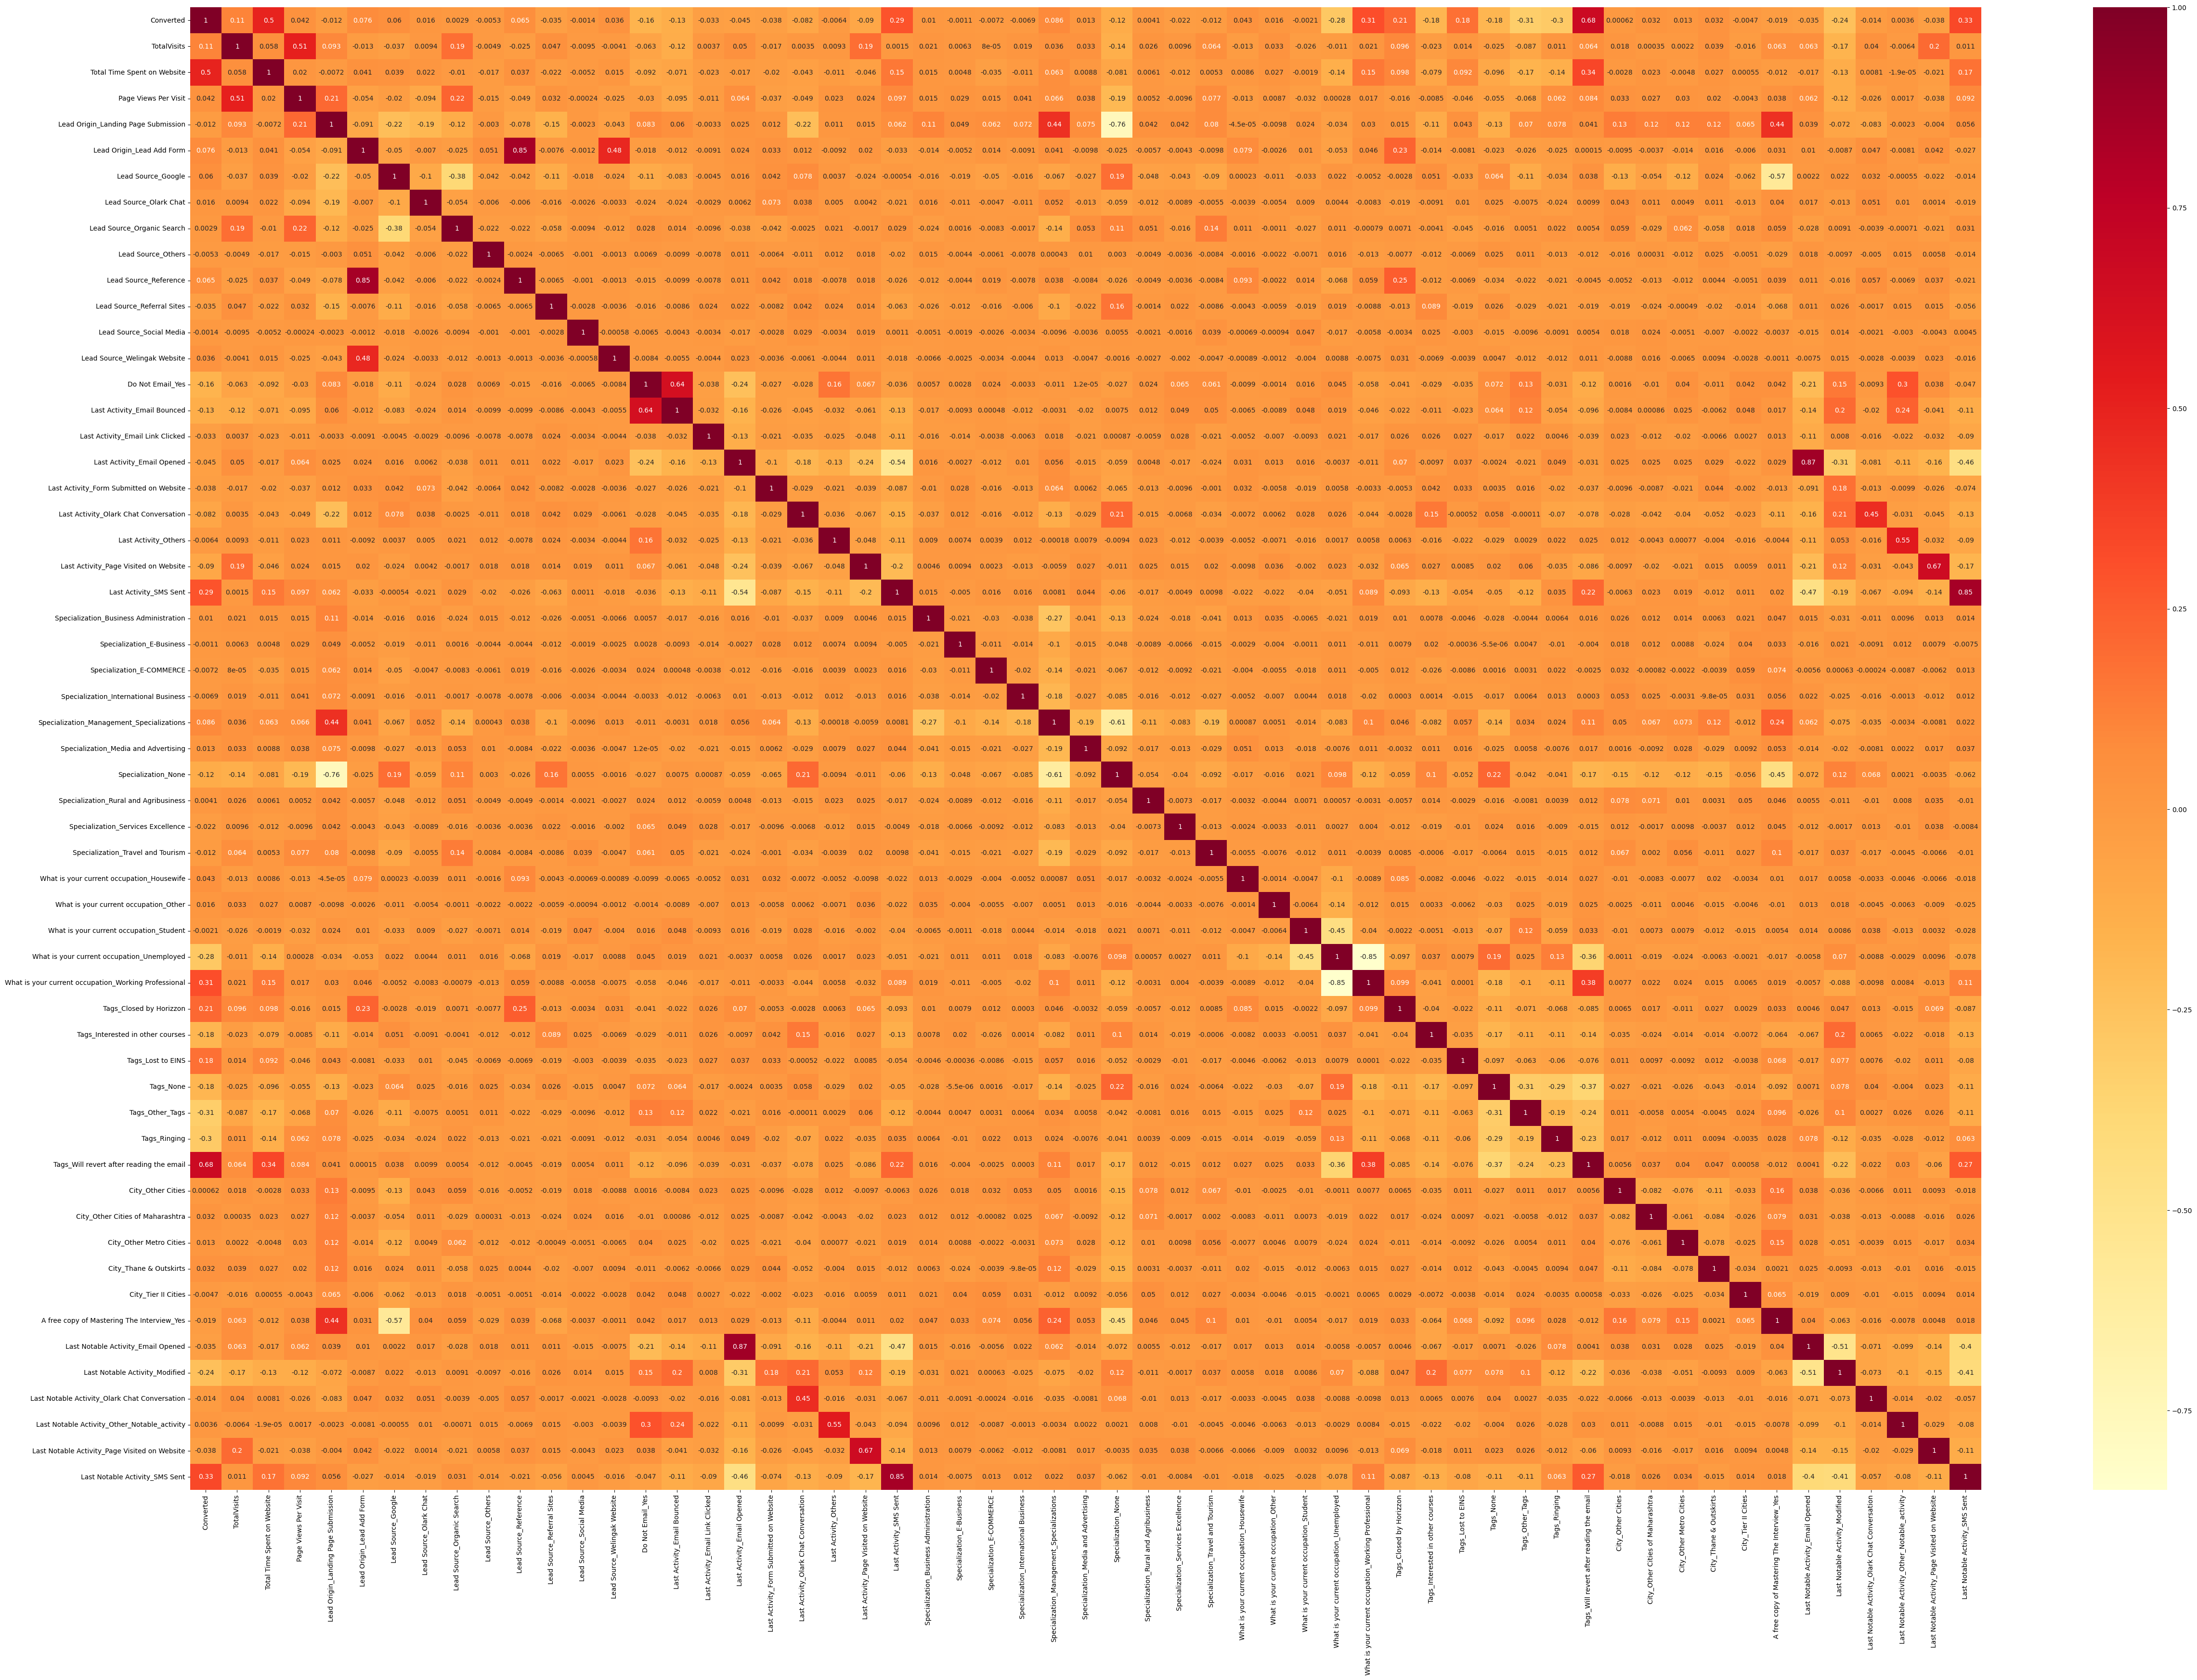

In [301]:
plt.figure(figsize = (60,40))        # Size of the figure
sns.heatmap(leads.corr(),cmap='YlOrRd',annot = True)
plt.savefig("sample_plot.pdf")
plt.show()

In [302]:
high_corr=['Lead Origin_Lead Add Form','Specialization_None','What is your current occupation_Unemployed','Last Notable Activity_Email Opened','Last Notable Activity_SMS Sent']

##### Dropping highly correlated dummy variables

In [303]:
X_test = X_test.drop(high_corr, axis=1)
X_train = X_train.drop(high_corr, axis=1)


KeyError: "['Lead Origin_Lead Add Form', 'Specialization_None', 'What is your current occupation_Unemployed', 'Last Notable Activity_Email Opened', 'Last Notable Activity_SMS Sent'] not found in axis"

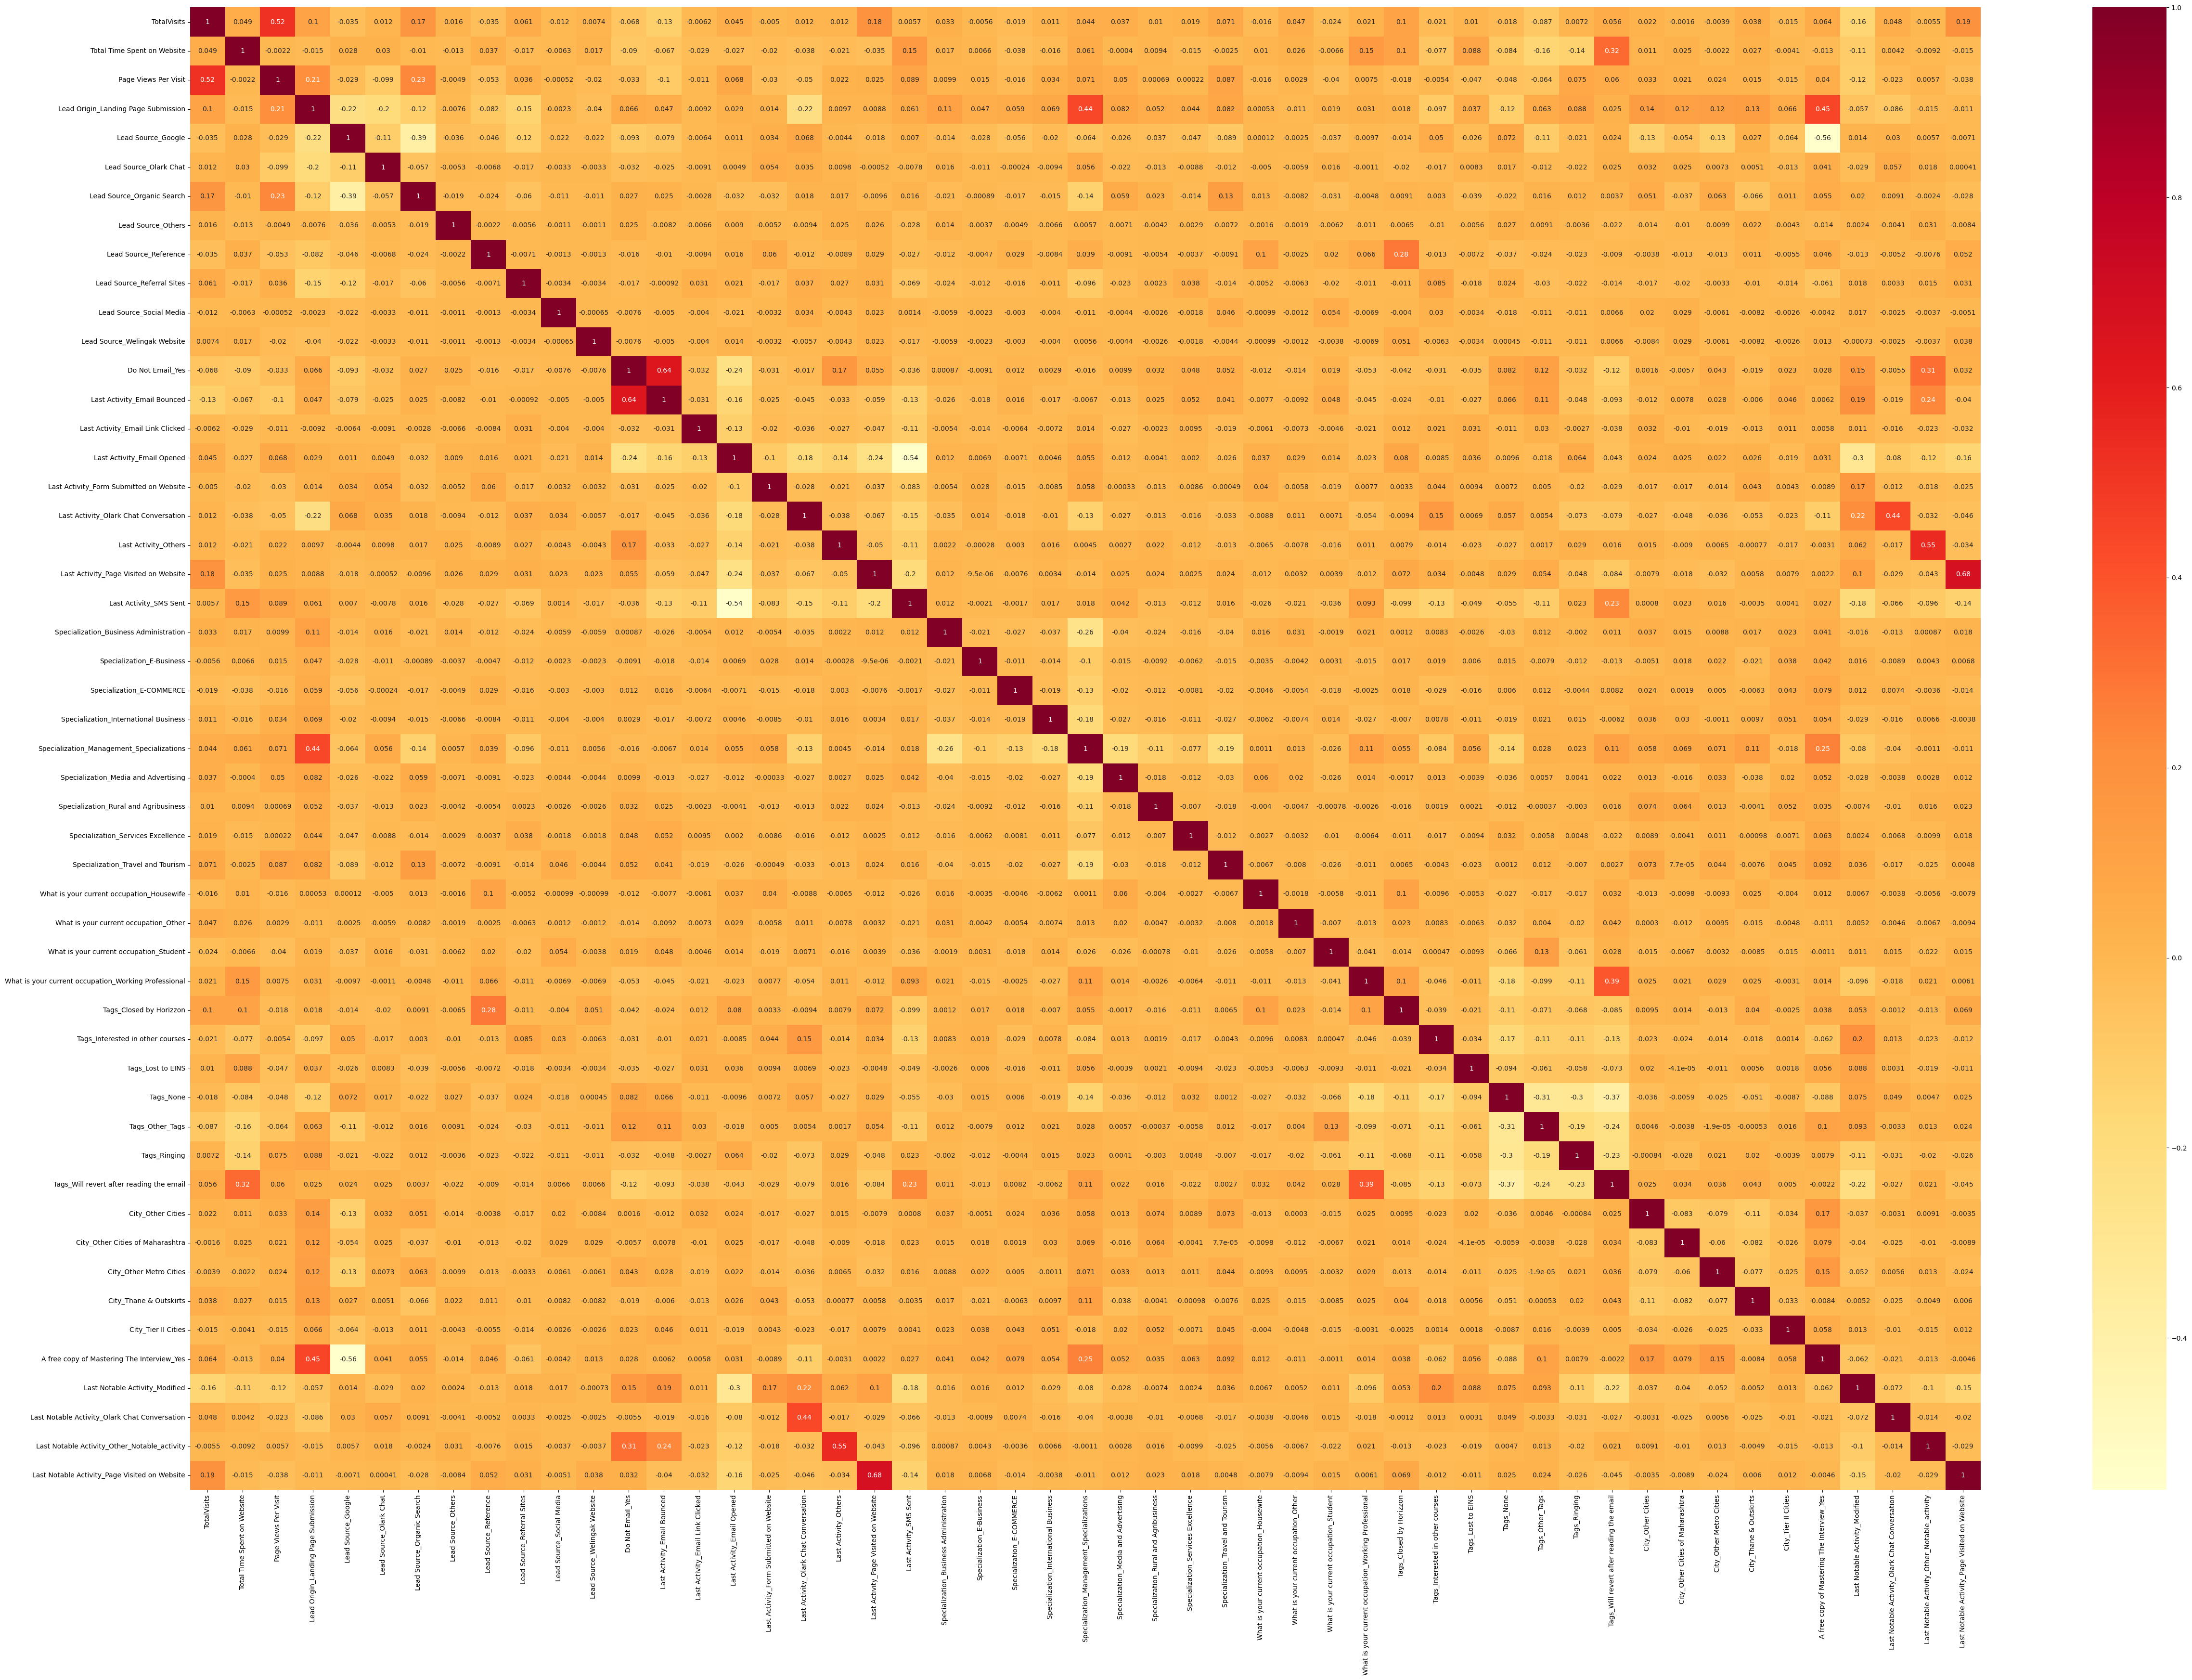

In [304]:
plt.figure(figsize = (60,40))
sns.heatmap(X_train.corr(),cmap='YlOrRd',annot = True)
plt.savefig("sample_plot2.pdf")
plt.show()

##### Model Building

In [305]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4648
Model:                            GLM   Df Residuals:                     4596
Model Family:                Binomial   Df Model:                           51
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -848.13
Date:                Sun, 18 Aug 2024   Deviance:                       1696.3
Time:                        09:50:52   Pearson chi2:                 7.68e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.6114
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.2473      0.500     -0.494      0.621      -1.228       0.733
TotalVisits                                              0.2075      0.077      2.712      0.007       0.058       0.358
Total Time Spent on Website                              1.1311      0.067     16.925      0.000       1.000       1.262
Page Views Per Visit                                    -0.1406      0.082     -1.717      0.086      -0.301       0.020
Lead Origin_Landing Page Submission                     -0.8221      0.249     -3.302      0.001      -1.310      -0.334
Lead Source_Google                                       0.2089      0.192      1.089      0.276      -0.167       0.585
Lead Source_Olark Chat                                  -0.5058      0.503     -1.005      0.315      -1.493       0.481
Lead Source_Organic Search                               0.2395      0.225      1.066      0.287      -0.201       0.680
Lead Source_Others                                       1.2552      1.203      1.043      0.297      -1.103       3.613
Lead Source_Reference                                   17.8400   4.69e+04      0.000      1.000   -9.19e+04    9.19e+04
Lead Source_Referral Sites                              -0.0512      0.511     -0.100      0.920      -1.053       0.951
Lead Source_Social Media                                -2.1563      1.877     -1.149      0.251      -5.835       1.522
Lead Source_Welingak Website                            25.1617   9.39e+04      0.000      1.000   -1.84e+05    1.84e+05
Do Not Email_Yes                                        -0.9893      0.364     -2.718      0.007      -1.703      -0.276
Last Activity_Email Bounced                             -0.2872      0.805     -0.357      0.721      -1.866       1.291
Last Activity_Email Link Clicked                         0.0661      0.561      0.118      0.906      -1.033       1.166
Last Activity_Email Opened                               0.0319      0.398      0.080      0.936      -0.748       0.812
Last Activity_Form Submitted on Website                  0.7621      0.640      1.191      0.234      -0.492       2.017
Last Activity_Olark Chat Conversation                    0.7328      0.481      1.523      0.128      -0.210       1.676
Last Activity_Others                                    -0.0471      0.756     -0.062      0.950      -1.529       1.435
Last Activity_Page Visited on Website                   -0.0287      0.556     -0.052      0.959      -1.118       1.060
Last Activity_SMS Sent                                   1.8616      0.390      4.774      0.000       1.097       2.626
Specialization_Business Administration                   0

##### Feature Selection using RFE

In [306]:
logreg = LogisticRegression()

##### keeping top 15 features

In [307]:
rfe = RFE(estimator=logreg, n_features_to_select=15)           
rfe = rfe.fit(X_train, y_train)

In [308]:
rfe.support_

array([False,  True, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True, False, False])

In [309]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 27),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 28),
 ('Lead Origin_Landing Page Submission', False, 2),
 ('Lead Source_Google', False, 23),
 ('Lead Source_Olark Chat', False, 15),
 ('Lead Source_Organic Search', False, 22),
 ('Lead Source_Others', True, 1),
 ('Lead Source_Reference', False, 26),
 ('Lead Source_Referral Sites', False, 29),
 ('Lead Source_Social Media', False, 7),
 ('Lead Source_Welingak Website', False, 5),
 ('Do Not Email_Yes', True, 1),
 ('Last Activity_Email Bounced', False, 11),
 ('Last Activity_Email Link Clicked', False, 36),
 ('Last Activity_Email Opened', False, 35),
 ('Last Activity_Form Submitted on Website', False, 3),
 ('Last Activity_Olark Chat Conversation', False, 9),
 ('Last Activity_Others', False, 37),
 ('Last Activity_Page Visited on Website', False, 25),
 ('Last Activity_SMS Sent', True, 1),
 ('Specialization_Business Administration', False, 14),
 ('Specialization_E-Business', False, 18),
 ('S

In [310]:
feature_select=X_train.columns[rfe.support_]

In [311]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'Lead Origin_Landing Page Submission', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_Welingak Website',
       'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked',
       'Last Activity_Email Opened', 'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Others',
       'Last Activity_Page Visited on Website',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_International Business',
       'Specialization_Management_Specializations',
       'Specialization_Media and Advertising',
       'Specialization_Rural and Agribusiness',
       'Specialization_Services Excellence',
       'What is your current occupation_Housewife',
       'What is your 

In [312]:
X_train_sm = sm.add_constant(X_train[feature_select])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4648
Model:                            GLM   Df Residuals:                     4632
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -876.09
Date:                Sun, 18 Aug 2024   Deviance:                       1752.2
Time:                        09:51:15   Pearson chi2:                 6.03e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.6067
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4698      0.244     -1.922      0.055      -0.949       0.009
Total Time Spent on Website                              1.1320      0.065     17.417      0.000       1.005       1.259
Lead Source_Others                                       1.5620      1.089      1.434      0.152      -0.573       3.697
Do Not Email_Yes                                        -1.0679      0.293     -3.642      0.000      -1.643      -0.493
Last Activity_SMS Sent                                   1.7158      0.134     12.814      0.000       1.453       1.978
Specialization_Travel and Tourism                       -0.9018      0.445     -2.028      0.043      -1.773      -0.030
What is your current occupation_Working Professional     1.2945      0.514      2.519      0.012       0.287       2.302
Tags_Closed by Horizzon                                 26.4290   1.84e+04      0.001      0.999   -3.59e+04     3.6e+04
Tags_Interested in other courses                        -2.9228      0.484     -6.040      0.000      -3.871      -1.974
Tags_Lost to EINS                                        4.4019      0.661      6.655      0.000       3.106       5.698
Tags_None                                               -0.9156      0.244     -3.757      0.000      -1.393      -0.438
Tags_Other_Tags                                         -3.2970      0.323    -10.193      0.000      -3.931      -2.663
Tags_Ringing                                            -4.2645      0.355    -12.020      0.000      -4.960      -3.569
Tags_Will revert after reading the email                 3.7546      0.322     11.652      0.000       3.123       4.386
Last Notable Activity_Modified                          -1.3221      0.147     -9.003      0.000      -1.610      -1.034
Last Notable Activity_Olark Chat Conversation           -0.5995      0.541     -1.108      0.268      -1.660       0.461
========================================================================================================================
"""

##### Getting the predicted values on the train set

In [313]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

1979    0.917548
6249    0.501837
5557    0.159129
7865    0.004213
8491    0.009595
2573    0.035195
474     0.023877
4477    0.977082
1952    0.065469
1816    0.000967
dtype: float64

In [314]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([9.17547666e-01, 5.01837118e-01, 1.59129180e-01, 4.21266001e-03,
       9.59549699e-03, 3.51952082e-02, 2.38768710e-02, 9.77081830e-01,
       6.54692445e-02, 9.67010499e-04])

In [315]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

Converted  Converted_Prob  LeadID
0          1        0.917548    1979
1          0        0.501837    6249
2          0        0.159129    5557
3          0        0.004213    7865
4          0        0.009595    8491

In [316]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Converted_Prob  LeadID  predicted
0          1        0.917548    1979          1
1          0        0.501837    6249          1
2          0        0.159129    5557          0
3          0        0.004213    7865          0
4          0        0.009595    8491          0

##### Confusion Matrix

In [317]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[2843  118]
 [ 205 1482]]


##### Overall Accuracy

In [318]:
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9305077452667814


##### Checking VIFs

In [319]:
vif = pd.DataFrame()
vif['Features'] = X_train[feature_select].columns
vif['VIF'] = [variance_inflation_factor(X_train[feature_select].values, i) for i in range(X_train[feature_select].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
13                     Last Notable Activity_Modified  1.77
12           Tags_Will revert after reading the email  1.67
3                              Last Activity_SMS Sent  1.55
9                                           Tags_None  1.47
5   What is your current occupation_Working Profes...  1.30
10                                    Tags_Other_Tags  1.28
0                         Total Time Spent on Website  1.19
7                    Tags_Interested in other courses  1.17
11                                       Tags_Ringing  1.17
2                                    Do Not Email_Yes  1.15
6                             Tags_Closed by Horizzon  1.07
8                                   Tags_Lost to EINS  1.05
4                   Specialization_Travel and Tourism  1.03
14      Last Notable Activity_Olark Chat Conversation  1.03
1                                  Lead Source_Others  1.00

##### All the varaibles have low VIF values indiacting no multicollinearity

In [320]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
confusion

array([[2843,  118],
       [ 205, 1482]])

In [321]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9305077452667814

## Metrics Beyond Accuracy

In [322]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [323]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8784825133372851

In [324]:
# Let us calculate specificity
TN / float(TN+FP)

0.9601485984464708

In [325]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.03985140155352921


In [326]:
# positive predictive value 
print (TP / float(TP+FP))

0.92625


In [327]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9327427821522309


### Step 9: Plotting the ROC Curve

In [328]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [329]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

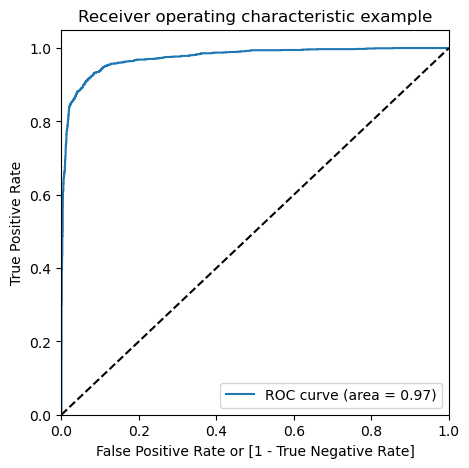

In [330]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

In [331]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Converted_Prob  LeadID  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          1        0.917548    1979          1    1    1    1    1    1    1   
1          0        0.501837    6249          1    1    1    1    1    1    1   
2          0        0.159129    5557          0    1    1    0    0    0    0   
3          0        0.004213    7865          0    1    0    0    0    0    0   
4          0        0.009595    8491          0    1    0    0    0    0    0   

   0.6  0.7  0.8  0.9  
0    1    1    1    1  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [332]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.362952  1.000000  0.000000
0.1   0.1  0.846816  0.969769  0.776765
0.2   0.2  0.912220  0.946058  0.892942
0.3   0.3  0.922547  0.920569  0.923674
0.4   0.4  0.926635  0.895080  0.944613
0.5   0.5  0.930508  0.878483  0.960149
0.6   0.6  0.929432  0.849437  0.975008
0.7   0.7  0.922547  0.819206  0.981425
0.8   0.8  0.909423  0.775341  0.985816
0.9   0.9  0.884897  0.700652  0.989868


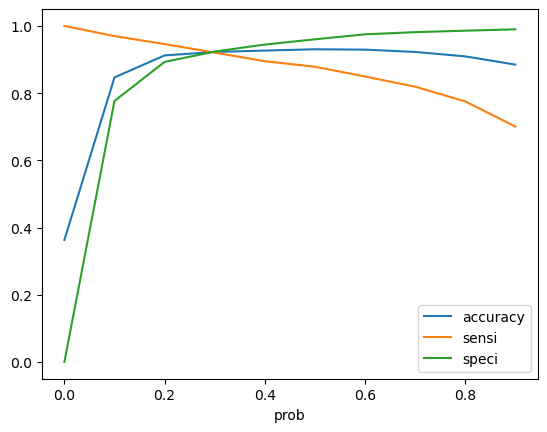

In [333]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [334]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

Converted  Converted_Prob  LeadID  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          1        0.917548    1979          1    1    1    1    1    1    1   
1          0        0.501837    6249          1    1    1    1    1    1    1   
2          0        0.159129    5557          0    1    1    0    0    0    0   
3          0        0.004213    7865          0    1    0    0    0    0    0   
4          0        0.009595    8491          0    1    0    0    0    0    0   

   0.6  0.7  0.8  0.9  final_predicted  
0    1    1    1    1                1  
1    0    0    0    0                1  
2    0    0    0    0                0  
3    0    0    0    0                0  
4    0    0    0    0                0

In [335]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9225473321858864

In [336]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[2735,  226],
       [ 134, 1553]])

In [337]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [338]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.920569057498518

In [339]:
# Let us calculate specificity
TN / float(TN+FP)

0.9236744343127322

In [340]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.07632556568726781


In [341]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8729623383923553


In [342]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9532938306029975


## Precision and Recall

In [343]:
from sklearn.metrics import precision_recall_curve

In [344]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

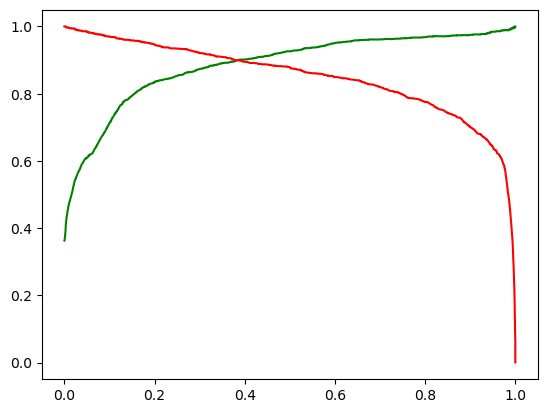

In [345]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [346]:
X_test[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']])

TotalVisits  Total Time Spent on Website  Page Views Per Visit
8970    -1.207883                    -0.573743             -1.264586
8280    -0.832700                    -0.248405             -0.642469
6941    -0.832700                    -1.035871             -1.264586
7343     4.795049                     0.017781             -0.561593
3734    -0.082334                    -0.595925              0.601766

In [353]:
X_test_lm = X_test[feature_select]

In [354]:
X_test_sm = sm.add_constant(X_test_lm)

In [355]:
feature_select

Index(['Total Time Spent on Website', 'Lead Source_Others', 'Do Not Email_Yes',
       'Last Activity_SMS Sent', 'Specialization_Travel and Tourism',
       'What is your current occupation_Working Professional',
       'Tags_Closed by Horizzon', 'Tags_Interested in other courses',
       'Tags_Lost to EINS', 'Tags_None', 'Tags_Other_Tags', 'Tags_Ringing',
       'Tags_Will revert after reading the email',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

In [356]:
y_test_pred = res.predict(X_test_sm)

In [357]:
y_test_pred[:10]

8970    0.004659
8280    0.158874
6941    0.010301
7343    0.713996
3734    0.032858
7889    0.730305
837     0.010153
8227    0.019592
7245    0.999539
8622    0.946785
dtype: float64

In [358]:
y_pred_1 = pd.DataFrame(y_test_pred)

In [359]:
# Let's see the head
y_pred_1.head()

0
8970  0.004659
8280  0.158874
6941  0.010301
7343  0.713996
3734  0.032858

In [360]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [361]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [362]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [363]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [364]:
y_pred_final.head()

Converted  CustID         0
0          0    8970  0.004659
1          0    8280  0.158874
2          0    6941  0.010301
3          0    7343  0.713996
4          0    3734  0.032858

In [367]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [369]:
y_pred_final.head()

Converted  CustID  Converted_Prob
0          0    8970        0.004659
1          0    8280        0.158874
2          0    6941        0.010301
3          0    7343        0.713996
4          0    3734        0.032858

In [374]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.4 else 0)

In [375]:
y_pred_final.head()

Converted  CustID  Converted_Prob  final_predicted
0          0    8970        0.004659                0
1          0    8280        0.158874                0
2          0    6941        0.010301                0
3          0    7343        0.713996                1
4          0    3734        0.032858                0

In [377]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.9186746987951807

In [379]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1173,   85],
       [  77,  657]])

In [380]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [381]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8950953678474114

In [382]:
# Let us calculate specificity
TN / float(TN+FP)

0.9324324324324325